# Use case 3: Signal production and ground distribution

In [1]:
import showermodel as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This notebook describes how to use the `Telescope` class to set the desired characteristics of a telescope and the `Signal` class to compute the signal produced in a telescope that detects a shower. The `Signal` class uses all the classes described in previous notebooks (i.e., `Atmosphere`, `Track`, `Telescope`, `Projection`, `Profile`, `Fluorescence`, `Cherenkov`). Special functions to show the time evolution of the signal and the photon distribution on ground are also described.

### Setting telescope characteristics

The `Telescope` class assumes a generic telescope with 100 % efficiency in the 290 - 430 nm range, aperture of 10 degrees and 100 m$^2$ area.

In [2]:
telescope1 = sm.Telescope()
print("Default telescope type:", telescope1.tel_type)
print("Default angular aperture in degrees:", telescope1.apert)
print("Default detection area in m2:", telescope1.area)

Default telescope type: None
Default angular aperture in degrees: 10.0
Default detection area in m2: 100.0


In addition, the `IACT` subclass is available. This subclass assumes the detection efficiency, angular aperture and detection area based on Medium Size Telescopes (MST) of CTA.

In [3]:
telescope2 = sm.IACT()
print("Generic telescope type:", telescope2.tel_type)
print("Angular aperture of generic telescope i n degrees:", telescope2.apert)
print("Detection area of generic telescope in m2:", telescope2.area)

Generic telescope type: IACT
Angular aperture of generic telescope i n degrees: 8.0
Detection area of generic telescope in m2: 113.097


The user can define a new telescope from these classes. To modify the detection efficiency, it must be input a `DataFrame` object with two columns: Wavelength in nm (with constant discretization step) and efficiency in decimal fraction.

In [4]:
efficiency = pd.DataFrame(columns=['wvl', 'eff']) 
efficiency.wvl = np.arange(300., 381., 1.)  # Last value is 380 nm
efficiency.eff = 0.5* np.exp(- ((efficiency.wvl - 337.) /10.)**2)  # Pass-band filter

telescope3 = sm.Telescope(tel_type='user_defined', efficiency=efficiency, apert=10., area=120.)
print("User-defined telescope type:", telescope3.tel_type)
print("Angular aperture in degrees:", telescope3.apert)
print("Detection area in m2:", telescope3.area)

User-defined telescope type: user_defined
Angular aperture in degrees: 10.0
Detection area in m2: 120.0


Below is a comparison of the detection efficiencies of the three above-defined `Telescope` objects.

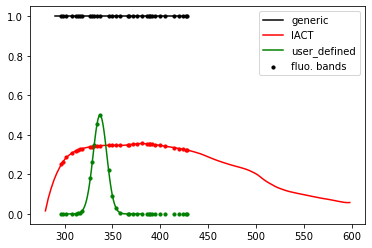

In [5]:
# telescope1
plt.plot(telescope1.wvl_cher, telescope1.eff_cher, 'k', label='generic');
plt.scatter(telescope1.wvl_fluo, telescope1.eff_fluo, color='k', s=10, label='fluo. bands');

# telescope2
plt.plot(telescope2.wvl_cher, telescope2.eff_cher, 'r', label='IACT');  # Efficieny defined in the range 280 - 600 nm
plt.scatter(telescope2.wvl_fluo, telescope2.eff_fluo, color='r', s=10);

# telescope3
plt.plot(telescope3.wvl_cher, telescope3.eff_cher, 'g', label='user_defined');
plt.scatter(telescope3.wvl_fluo, telescope3.eff_fluo, color='g', s=10);
plt.legend();

A new telescope can also be defined by the user from an existing `Telescope` object, but with some changes.

In [6]:
telescope4 = telescope2.copy(x=0.1, y=-0.2, theta=20., az=120., area=50., tel_type='my_tel')

Help on `Telescope`.

In [7]:
# sm.Telescope?

### Signal production

The number of photons from a shower that are collected by a telescope can be obtained by computing the fraction of solid angle covered by the telescope area subtended at each shower point and the atmospheric transmission. In this code, only Rayleigh scattering is considered to evaluate the atmospheric transmission taking a mass attenuation length of 1645 g/cm$^2$ at 350 nm, increasing with wavelength to the fourth power.  
The Cherenkov light is assumed to follow a $1/\lambda^2$ distribution, whereas the fluorescence production is calculated for the 34 bands between 290 and 430nm (circles of the figure above).

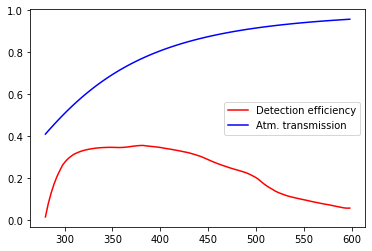

In [8]:
telescope = sm.IACT()

wvl = telescope.wvl_cher
plt.plot(wvl, telescope.eff_cher, 'r', label='Detection efficiency');
plt.plot(wvl, np.exp(-600./1645*(350./wvl)**4), 'b', label='Atm. transmission')  # Shower-to-telescope distance of 600g/cm2
plt.legend();

The calculated signal production is stored in a `Signal` object that is constructed from a `Shower` and `Telescope` objects.

In [9]:
shower = sm.Shower(theta=20., az=30.)
telescope = sm.IACT(x=0.3, y=-0.2, theta=22., az=30.)

signal = sm.Signal(telescope, shower)

By default, both the atmospheric transmission and telescope efficiency are included, but they may be turned off.

In [10]:
# signal = sm.Signal(telescope, shower, atm_trans=False, tel_eff=False)

If the telescope efficiency is not included, the wavelength range defined in the `Telescope` object is used, unless it is modified via the parameters `wvl_ini`, `wvl_fin` and `wvl_step`, where `wvl_step` is the discretization step to integrate the wavelenght-dependent atmospheric transmission.

In [11]:
# signal = sm.Signal(telescope, shower, tel_eff=False, wvl_ini=350., wvl_fin=500., wvl_step=5.)

The resulting `Signal` object is a subclass of `DataFrame`. It stores the number of photoelectrons for shower points within the telescope field of view.

In [12]:
signal

,Npe_cher,Npe_fluo,Npe_total
27,170.943719,9.662364e-01,171.909956
28,162.391762,8.789635e-01,163.270725
29,153.355354,7.970016e-01,154.152355
30,143.411226,7.203336e-01,144.131560
31,133.893892,6.489109e-01,134.542803
...,...,...,...
187,0.000022,1.048646e-07,0.000022
188,0.000022,1.026602e-07,0.000022
189,0.000021,9.839726e-08,0.000021
190,0.000020,9.433034e-08,0.000020


Note: The very beginning of the shower profile (s<0.01) is ignored to speed up calculations.

A `Signal` object contains a `Shower` and `Telescope` objects, as well as a `Projection` object that is constructed from these objects.

In [13]:
# signal.shower
# signal.telescope
# signal.projection
# signal.atmosphere  # Equivalent to signal.shower.atmosphere or signal.projection.atmosphere
# signal.track

There are some useful attributes of the `Signal` objects.

In [14]:
print("Atmospheric transmission included:", signal.atm_trans)
print("Telescope efficiency included:", signal.tel_eff)
print("Wavelenght range:", (signal.wvl_ini, signal.wvl_fin, signal.wvl_step))
print("Sum of photoelectrons due to Cherenkov light:", signal.Npe_cher_sum)
print("Sum of photoelectrons due to fluorescence light:", signal.Npe_fluo_sum)
print("Sum of photoelectrons due to both light components:", signal.Npe_total_sum)

Atmospheric transmission included: True
Telescope efficiency included: True
Wavelenght range: (280.0, 600.0, 3.0)
Sum of photoelectrons due to Cherenkov light: 1954.9150373114046
Sum of photoelectrons due to fluorescence light: 8.817558288073343
Sum of photoelectrons due to both light components: 1963.732595599478


`Signal` objects include a method to plot the signal evolution as a function of both time and beta angle, which is the angular distance of the shower track from the telescope point of view.

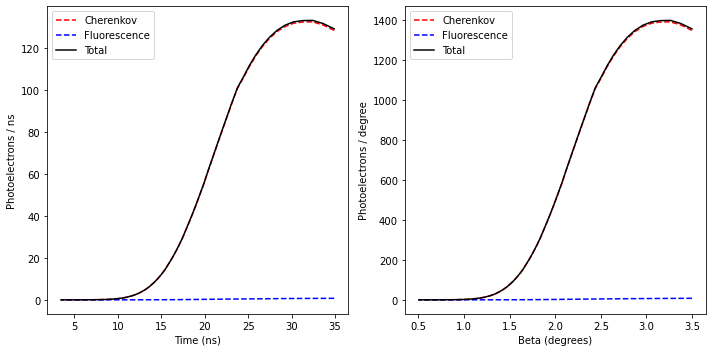

In [15]:
signal.show();

There are also some inherited methods from `Shower` and `Projection`.

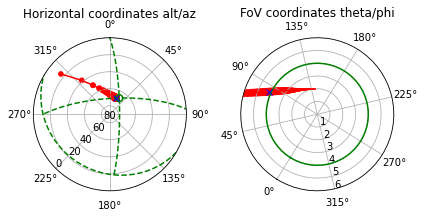

In [16]:
# signal.show_profile();
# signal.show_light_production();
signal.show_projection(max_theta=6.);  # Equivalent to shower.show_projection(telescope, max_theta=6.)

Help on `Signal`.

In [17]:
# sm.Signal?

### Example of signal calculation in 'fluorescence mode'

1 EeV proton shower observed transversely by a fluorescence telescope similar to an IACT, but with larger aperture. The telescope is pointed at the shower maximum.

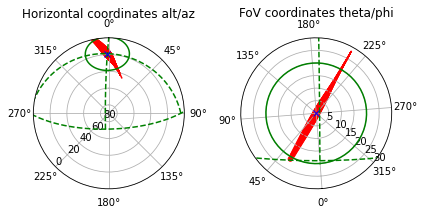

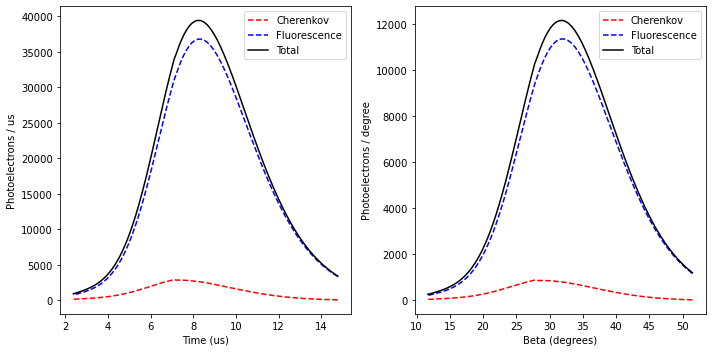

In [18]:
shower = sm.Shower(E=1.e12, prf_model='Gaisser-Hillas', X_max=500., x0=-2.5, y0=12., theta=45., az=20.)
# Large FoV fluorescence telescope at the origin of coordinates
telescope = sm.IACT(apert=40., tel_type='fluo_tel')

x, y, z = shower.track.X_to_xyz(500.)  # Coordinates of shower maximum
distance, alt, az, theta, phi = telescope.spherical(x, y, z)
telescope = telescope.copy(alt=alt, az=az)  # Telescope pointing at shower maximum
signal = sm.Signal(shower, telescope)

signal.show_projection(max_theta=30.);
signal.show();

### Photon distribution at observation level

The method `show_distribution` of `Shower` calculates the photon distribution at observation level and plot it. By default, the photon distribution is calculated on a square grid of 2x2 km$^2$ on ground with discretization size of 0.2 km around the origin of the coordinate system, the wavelenght range is 290-430 nm and the atmospheric transmission is included. But the grid position, height, dimensions and discretization size can be modified by the user.

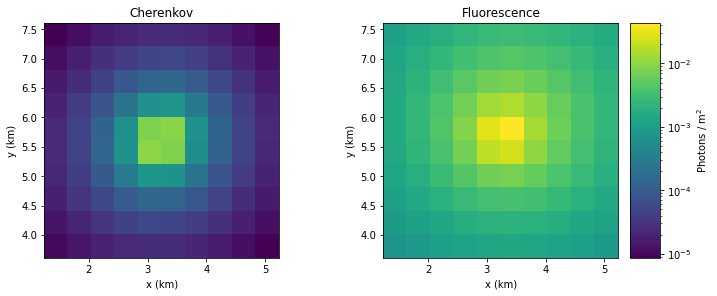

In [19]:
shower = sm.Shower(theta=20., az=30.)

# Default photon distribution
# shower.show_distribution();

# Setting grid position, height, dimensions and discretization size
x_c, y_c, z_c = shower.track.h_to_xyz(20.)  # Coordinates of shower point at 20 km a.s.l.
shower.show_distribution(x_c=x_c, y_c=y_c, z_c=z_c, size_x=4., size_y=4., N_x=10, N_y=10);  # Distribution at 20km a.s.l.

In case of a linear grid (i.e., `N_x=1` or `N_x=1`), a 1D plot is generated instead.

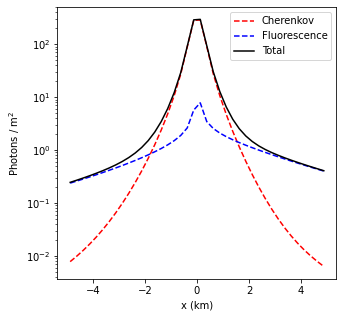

In [20]:
shower.show_distribution(size_x=10., N_x=40, N_y=1);

The wavelength range can be modified and the atmospheric transmission can be turned off.

In [21]:
# shower.show_distribution(wvl_ini=350., wvl_fin=500., atm_trans=False);

This method also allows for the calculation of density of photons in a given wavelengh range that would be collected by a grid of identical telescopes with a certain mirror area and field of view around a common pointing direction.

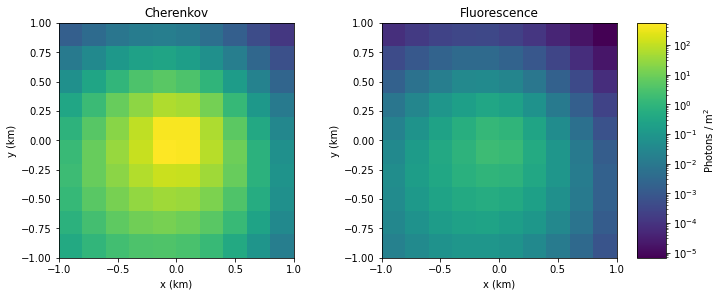

In [22]:
shower = sm.Shower(theta=20., az=30.)
shower.show_distribution(telescope=telescope3, theta=22., az=30., wvl_ini=300., wvl_fin=450.);

# Equivalent to 
# telescope5 = telescope3.copy(theta=22., az=30.)
# shower.show_distribution(telescope=telescope5, wvl_ini=300., wvl_fin=450.);

Note: If `wvl_ini`, `wvl_fin` and `wvl_step` are not given, those of the input telescope will be used (but not the detection efficiency).

In this case, the telescope efficiency can be turn on to obtain the photoelectron distribution instead of the photon distribution.

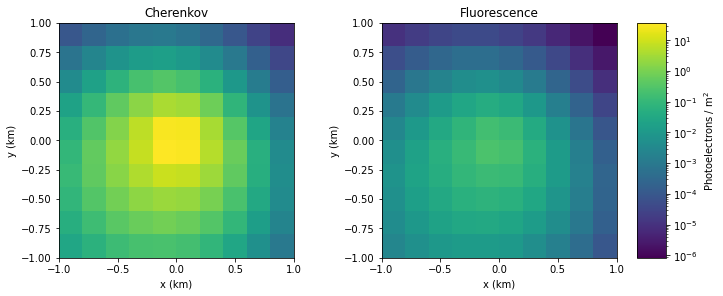

In [23]:
shower.show_distribution(telescope=telescope3, theta=22., az=30., tel_eff=True);

Note: If `tel_eff=True`, the parameters `wvl_ini`, `wvl_fin` and `wvl_step` are unused, because the wavelenght range defined in the input `Telescope` object is always used.

Help on `show_distribution`.

In [24]:
# shower.show_distribution?